In [48]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os


#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler


#nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [49]:
subreddits = pd.read_csv('../csv_data/master_subreddit.csv')

In [50]:
subreddits.head()

,id,subreddit,title,posttext,time_posted,time_now,time_difference,num_comments,upvote_ratio,url
0,17lfevw,fastfood,McDonald's Revenue Is Way Up Because Menu Pric...,NaN,2023-11-01 16:01:24,2024-04-08 22:47:41.643404,159 days 06:46:17.643404,550,0.97,https://www.delish.com/food-news/a45697179/mcd...
1,1bux2fj,fastfood,"McDonald's has doubled its prices since 2014, ...",NaN,2024-04-03 16:31:03,2024-04-08 22:47:41.643410,5 days 06:16:38.643410,324,0.98,https://scrippsnews.com/stories/this-fast-food...
2,18ap0ug,fastfood,'Most Big Macs aren't that expensive': A $16 M...,NaN,2023-12-04 17:19:35,2024-04-08 22:47:41.643413,126 days 05:28:06.643413,590,0.95,https://finance.yahoo.com/news/most-big-macs-a...
3,1ajnc5q,fastfood,McDonald’s CEO: ‘The battleground is with the ...,NaN,2024-02-05 18:16:13,2024-04-08 22:47:41.643415,63 days 04:31:28.643415,534,0.98,https://www.nrn.com/finance/mcdonald-s-ceo-bat...
4,18kn8v2,fastfood,Boston Market fast-food chain on the brink as ...,NaN,2023-12-17 18:08:16,2024-04-08 22:47:41.643418,113 days 04:39:25.643419,267,0.99,https://www.dailymail.co.uk/news/article-12873...


In [51]:
subreddits.columns

Index(['id', 'subreddit', 'title', 'posttext', 'time_posted', 'time_now',
       'time_difference', 'num_comments', 'upvote_ratio', 'url'],
      dtype='object')

In [52]:
subreddits.rename(columns={'posttext': 'selftext'}, inplace=True)

In [53]:
subreddits.dtypes

id                  object
subreddit           object
title               object
selftext            object
time_posted         object
time_now            object
time_difference     object
num_comments         int64
upvote_ratio       float64
url                 object
dtype: object

In [54]:
subreddits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4872 non-null   object 
 1   subreddit        4872 non-null   object 
 2   title            4872 non-null   object 
 3   selftext         909 non-null    object 
 4   time_posted      4872 non-null   object 
 5   time_now         4872 non-null   object 
 6   time_difference  4872 non-null   object 
 7   num_comments     4872 non-null   int64  
 8   upvote_ratio     4872 non-null   float64
 9   url              4872 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 380.8+ KB


#### Imputing Missing Values
- Posttext (actual name was selftext)

In [55]:
subreddits['selftext'].fillna('title', inplace = True)

In [56]:
subreddits['selftext'].value_counts()
print(f'Self Text Null is: {subreddits["selftext"].isnull().sum()}')

Self Text Null is: 0


In [57]:
subreddits.isna().sum()

id                 0
subreddit          0
title              0
selftext           0
time_posted        0
time_now           0
time_difference    0
num_comments       0
upvote_ratio       0
url                0
dtype: int64

In [73]:
#master_df.duplicated(title).sum()
subreddits.duplicated(subset=['title']).sum()

1

In [74]:
subreddits.drop_duplicates(subset=['selftext'], inplace=True)

subreddits.duplicated(subset=['selftext']).sum()

0

In [75]:
subreddits.shape

(815, 12)

In [61]:
def preprocess_dataframe(df):
    # Normalize numerical columns
    numerical_cols = ['upvote_ratio', 'num_comments']
    df[numerical_cols] = StandardScaler().fit_transform(df[numerical_cols])

    # Process 'time_posted' column (timestamp)
    df['time_posted'] = pd.to_datetime(df['time_posted'])  # No need to specify unit

    # Extract hour_of_day and day_of_week from 'time_posted'
    df['hour_of_day'] = df['time_posted'].dt.hour
    df['day_of_week'] = df['time_posted'].dt.dayofweek

    # Drop 'time_posted' column after extracting hour_of_day and day_of_week
    df = df.drop('time_posted', axis=1)

    return df

In [62]:
#Checking the cleaned data
processed_subreddits = preprocess_dataframe(subreddits)
print(processed_subreddits.shape)
print(processed_subreddits.tail(10))

(815, 11)
           id    subreddit                                              title  \
4722  1031uqk  HealthyFood      What are some healthy alternatives to snacks?   
4723  102voj4  HealthyFood                     Healthy cookbook for beginners   
4724  102vc8h  HealthyFood                                    Craving cabbage   
4725  102q1y6  HealthyFood                     Is Bloom Greens truly healthy?   
4726  102pkee  HealthyFood                                   Sugar Free Mayo?   
4727  102obu1  HealthyFood  Is it "Healthy" to eat like this every day for...   
4728  102j6pf  HealthyFood                     Chicken raw or cooked question   
4729  102hje6  HealthyFood  Anything more filling and low calorie than cro...   
4730  102ftmz  HealthyFood                              A soup for every day?   
4732   iyaooy  HealthyFood  /r/HealthyFood Rules - Be sure to go over this...   

                                               selftext  \
4722  Mainly looking for something crun

In [63]:
'''This function will clean and normalize the text data to make 
it suitable for further analysis and modeling in NLP tasks. '''

def preprocess_text(text):
 
    # Lowercasing the text
    text = text.lower()
    # Removing special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    # Tokenize into words
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words("english", "ascii"))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [64]:
'''  
The code involves preparing the data through preprocessing steps and dividing it into
training and testing sets. Additionally, it creates a vectorizer object to transform
the text data into numerical representations appropriate for NLP tasks.
'''
def prepare_data_for_nlp(df, text_column='selftext', target_column='subreddit'):
    
    # Preprocess text data
    df[text_column] = df[text_column].apply(lambda x: preprocess_text(str(x)))

    # Split dataset into features and target variable
    X = df[text_column]
    y = df[target_column]

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vectorization - using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)

    return X_train_vect, X_test_vect, y_train, y_test, vectorizer

In [65]:
#splitting the data into training and testing sets
X_train, X_test, y_train, y_test, vectorizer = prepare_data_for_nlp(processed_subreddits)

In [66]:
X_train

<652x4327 sparse matrix of type '<class 'numpy.float64'>'
	with 20729 stored elements in Compressed Sparse Row format>

In [67]:
X_test

<163x4327 sparse matrix of type '<class 'numpy.float64'>'
	with 4181 stored elements in Compressed Sparse Row format>

In [68]:
pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())

,_____,_b,_kbpflcdmnys,_members,_redditors_are_subscribed_to_the,_subscribe,_subscribers,_subscribers_for_rfastfood,_subscribers_greetings_to_all_the_new,_subscribers_to_the_fastfood_subreddit,...,yummy,za,zaxby,zero,zesty,zevia,zinc,zoo,zucchini,zuchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
#saving it
td_idf_df = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())

In [70]:
#sum the tdidf score
word_frequencies = td_idf_df.sum(axis = 0).to_dict()

In [71]:
# Convert dictionary to DataFrame
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency'])

# Sort DataFrame by frequency in descending order
word_freq_df_sorted = word_freq_df.sort_values(by='Frequency', ascending=False)

print(word_freq_df_sorted)

              Word  Frequency
2167          like  19.716412
1738       healthy  16.485841
1204           eat  16.457205
1498          food  14.165058
1628          good  13.730474
...            ...        ...
166   antagonistic   0.017806
3692      striving   0.017806
2579       offered   0.017806
2425      morality   0.017806
697       claiming   0.017806

[4327 rows x 2 columns]


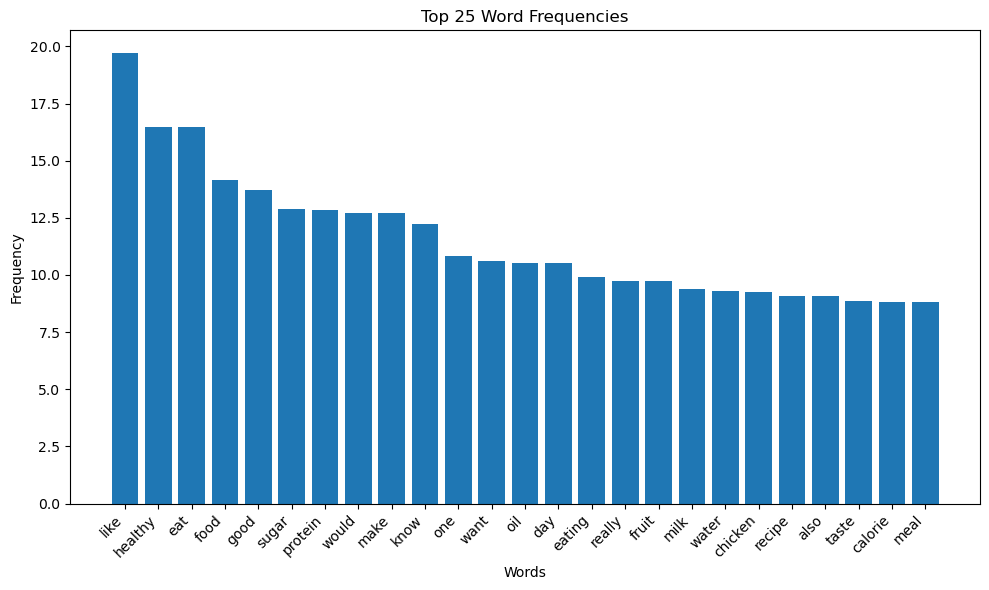

In [72]:
# Select the top 25 rows
top_25_words = word_freq_df_sorted.head(25)

# Plot the top 25 words as a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(top_25_words['Word'], top_25_words['Frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 25 Word Frequencies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()